In [ ]:
"""
Copyright (c) 2024 Egor Sedov

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, subject to the following conditions:

1. Attribution: You must give appropriate credit, provide a link to the license,
   and indicate if changes were made. You may do so in any reasonable manner, but
   not in any way that suggests the licensor endorses you or your use.

2. No Cloning without Citation: You are not allowed to clone this repository or
   any substantial part of it without citing the author. Citation must include
   the author's name (Egor Sedov) and contact email (egor.sedoff+git@gmail.com).

3. The above copyright notice and this permission notice shall be included in
   all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY,
WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
"""

In [1]:
import pandas as pd
import numpy as np
import hpcom
import itertools
from tqdm import tqdm
import matplotlib.pyplot as plt
import matlab.engine
from matplotlib import cm
import seaborn as sns
import os
from scipy.stats import multivariate_normal
import plotly.graph_objects as go
from sklearn.mixture import GaussianMixture
from mpl_toolkits.mplot3d import Axes3D


In [2]:
# pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

### Functions for fitting of nonlinear effects  
For fitting other types (like channel noise) we need to form dataset differently

In [3]:
def form_datasets_triplets(df, runs, p_ave_dbm, M_shifted, M_orig, channel_noise=False):
    dataset = []
    target_dataset = []

    # Pre-fetch data for all runs
    data_for_runs = df[df.run.isin(runs) & (df.p_ave_dbm == p_ave_dbm)]
    scale_coef = df[(df.run == runs[0]) & (df.p_ave_dbm == p_ave_dbm)].scale_coef.values[0]

    for _, row in tqdm(data_for_runs.iterrows()):
        if channel_noise:
            points_shifted = (row['points_shifted'][0] - row['points_shifted_wo_noise'][0] + row['points_orig'][0]) * scale_coef  # here shifted poins are with noise and nonlinear effects, while wo_noise are without noise but with nonlinear effects. We need to add original points to get only channel noise effects for each constellation point (they will be at their original positions as constellation)
        else:
            points_shifted = row['points_shifted'][0] * scale_coef  # here shifted points has only nonlinear effects (no channel noise)
        points_orig = row['points_orig'][0] * scale_coef

        # Use Numpy for efficient extraction of neighbors
        extended_points_shift = np.concatenate([points_shifted[-M_shifted:], points_shifted, points_shifted[:M_shifted]])
        extended_points_orig = np.concatenate([points_orig[-M_orig:], points_orig, points_orig[:M_orig]])

        for i in range(len(points_shifted)):

            neighbors_shift = extended_points_shift[i:i + 2 * M_shifted + 1]

            # Interleave real and imaginary parts
            interleaved = np.empty(2 * len(neighbors_shift), dtype=neighbors_shift.dtype)
            interleaved[0::2] = neighbors_shift.real
            interleaved[1::2] = neighbors_shift.imag

            dataset.append(interleaved)

            neighbors_orig = extended_points_orig[i:i + 2 * M_orig + 1]

            # Interleave real and imaginary parts
            interleaved = np.empty(2 * len(neighbors_orig), dtype=neighbors_orig.dtype)
            interleaved[0::2] = neighbors_orig.real
            interleaved[1::2] = neighbors_orig.imag

            target_dataset.append(interleaved)

    return np.array(dataset), np.array(target_dataset)


def fit_gauss_matlab(X, H, plotlik=0, plotsolution=0, maxit=50, minDeterminant=0.0001, eng=None):
    """

    Args:
        X:

    Returns:

        - P : learned mixture coefficients
        - m :learned means
        - S : learned covariances
        - loglik is the log likelihood
        - phgn are the mixture assignment probabilties

    """

    brml_location = r'C:/Users/190243539/PycharmProjects/nn_essential/error_statistics/BRMLtoolkit/'

    # Start MATLAB engine
    flag_start_end = False
    if eng is None:
        eng = matlab.engine.start_matlab()
        flag_start_end = True

    eng.addpath(brml_location, nargout=0)
    eng.addpath(brml_location + '+brml/', nargout=0)

    # Convert data to MATLAB format
    X_matlab = matlab.double(X.tolist())
    # Convert H to MATLAB double
    H_matlab = eng.double(H)

    # Set options for GMMem function
    opts = eng.struct()

    opts['plotlik'] = plotlik
    opts['plotsolution'] = plotsolution
    opts['maxit'] = maxit
    opts['minDeterminant'] = minDeterminant

    # Call GMMem function
    P, m, S, loglik, phgn = eng.brml.GMMem(X_matlab, H_matlab, opts, nargout=5)

    # Convert MATLAB outputs to numpy arrays
    P = np.asarray(P)
    m = np.asarray(m)
    m = np.array(m).T
    S = np.asarray(S)
    if H == 1:
        P = np.array([P])
        S = S.reshape((1,-1))
    else:
        P = P.reshape(-1)
        S = S.transpose(2, 0, 1).reshape(H, -1)

    phgn = np.asarray(phgn)

    # Terminate MATLAB engine
    if flag_start_end:
        eng.quit()

    eigenvalues = []
    for S_cur in S:
        eigenvalues.append(np.linalg.eigvals(S_cur.reshape(2, 2)))

    eigenvalues = np.array(eigenvalues)

    return {'P': P,
            'm': m,
            'S': S,
            'eig': eigenvalues,
            'loglik': loglik,
            'phgn': phgn}


def fit_triplets(df: pd.DataFrame, path_to_save: str, matlab_engine: matlab.engine.MatlabEngine, 
                 disp: bool = False, H_max: int = 1, independant_gauss: bool = False) -> pd.DataFrame:
    
    # Initialize an empty DataFrame
    df_result = pd.DataFrame()

    constellation = hpcom.modulation.get_constellation('16qam')
    # triplets = list(itertools.product(constellation, constellation[:1], constellation[:1]))  # for test purposes
    triplets = list(itertools.product(constellation, constellation, constellation))

    for triplet in tqdm(triplets):

        triplet_left_point = triplet[0]
        triplet_central_point = triplet[1]
        triplet_right_point = triplet[2]

        epsilon = 1e-10
        condition = (
            np.isclose(df.orig_m1_real, np.real(triplet_left_point), atol=epsilon) &
            np.isclose(df.orig_m1_imag, np.imag(triplet_left_point), atol=epsilon) &
            np.isclose(df.orig_real, np.real(triplet_central_point), atol=epsilon) &
            np.isclose(df.orig_imag, np.imag(triplet_central_point), atol=epsilon) &
            np.isclose(df.orig_p1_real, np.real(triplet_right_point), atol=epsilon) &
            np.isclose(df.orig_p1_imag, np.imag(triplet_right_point), atol=epsilon)
        )

        df_one = df[condition]


        row_data = {
                'left_point_real': triplet_left_point.real,
                'left_point_imag': triplet_left_point.imag,
                'central_point_real': triplet_central_point.real,
                'central_point_imag': triplet_central_point.imag,
                'right_point_real': triplet_right_point.real,
                'right_point_imag': triplet_right_point.imag,
            }

        x = df_one.shifted_real.values - triplet_central_point.real
        y = df_one.shifted_imag.values - triplet_central_point.imag
        data_to_fit = np.stack((x, y), axis=0)

        # Loop over different values of H
        for H in range(1, H_max + 1):
            result = fit_gauss_matlab(data_to_fit, H=H, plotlik=0, plotsolution=0, maxit=50, minDeterminant=0.0001, eng=matlab_engine)

            # Extract parameters
            P = result['P']
            m = result['m']
            S = result['S']
            eig = result['eig']
            loglik = result['loglik']

            # Add the log-likelihood to the row
            row_data[f'h{H}_loglik'] = loglik

            # Add the parameters for each Gaussian component
            for i in range(H):
                row_data[f'h{H}_prob_{i+1}'] = P[i]
                row_data[f'h{H}_mean0_{i+1}'] = m[i, 0]
                row_data[f'h{H}_mean1_{i+1}'] = m[i, 1]
                row_data[f'h{H}_cov00_{i+1}'] = S[i, 0]
                row_data[f'h{H}_cov01_{i+1}'] = S[i, 1]
                row_data[f'h{H}_cov10_{i+1}'] = S[i, 2]
                row_data[f'h{H}_cov11_{i+1}'] = S[i, 3]
                row_data[f'h{H}_eig0_{i+1}'] = eig[i, 0]
                row_data[f'h{H}_eig1_{i+1}'] = eig[i, 1]
                
        if independant_gauss:
            energy_noise_for_points = np.mean(np.abs(x + 1j * y) ** 2) / 2
            sigma_for_points = np.sqrt(energy_noise_for_points)
            row_data['sigma_independent_gauss'] = sigma_for_points

        # Append the row to the DataFrame
        df_result = pd.concat([df_result, pd.DataFrame([row_data])], ignore_index=True)
        # df_result = df_result.append(row_data, ignore_index=True)

    df_result.to_pickle(path_to_save)
    df_result.to_parquet(path_to_save[:-3] + 'parquet', engine='pyarrow')

    return df_result


def form_column_names(M_shift, M_orig):
    column_names = []
    for i in range(2*M_shift+1):
        if i < M_shift:
            prefix = f'shifted_m{abs(i-M_shift)}'  # Replace "-" with "m"
        elif i == M_shift:
            prefix = 'shifted'
        else:
            prefix = f'shifted_p{i-M_shift}'
        column_names.extend([f'{prefix}_real', f'{prefix}_imag'])

    for i in range(2*M_orig+1):
        if i < M_orig:
            prefix = f'orig_m{abs(i-M_orig)}'  # Replace "-" with "m"
        elif i == M_orig:
            prefix = 'orig'
        else:
            prefix = f'orig_p{i-M_orig}'
        column_names.extend([f'{prefix}_real', f'{prefix}_imag'])

    return column_names

 
# def form_dataframes(p_ave_dbm_list, data_dir, filename_prefix, m_shift, m_orig):
# 
#     df_result = pd.DataFrame()
# 
#     for p_ave_dbm in p_ave_dbm_list:
#         filename = filename_prefix + str(p_ave_dbm) + ".pkl"
#         df = pd.read_pickle(data_dir + filename)
# 
#         print('Forming datasets')
#         n_runs = 64
#         runs = [k for k in range(n_runs)]  # Replace with your list of runs
#         dataset, target_dataset = form_datasets_triplets(df, runs, p_ave_dbm, m_shift, m_orig)
#         df_new = pd.concat([pd.DataFrame(dataset), pd.DataFrame(target_dataset)], axis=1).astype(float)
#         df_new.columns = form_column_names(m_shift, m_orig)
# 
#         df_new.to_pickle(data_dir + filename[:-4] + '_triplets.pkl')
#         df_new.to_parquet(data_dir + filename[:-4] + '_triplets.parquet', engine='pyarrow')
# 
#         df_new['p_ave_dbm'] = p_ave_dbm
#         df_result = pd.concat([df_result, df_new], ignore_index=True)
# 
#     df_result.to_pickle(data_dir + filename_prefix + '_triplets_all_powers.pkl')
#     df_result.to_parquet(data_dir + filename_prefix + '_triplets_all_powers.parquet', engine='pyarrow')
# 
#     return df_result


def fit_all(p_ave_dbm_list: list[float], data_dir: str, filename_prefix: str, n_runs: int = 64, 
            H_max: int = 1, independant_gauss: bool = False, channel_noise: bool = False) -> pd.DataFrame:
    
    eng = matlab.engine.start_matlab()

    for p_ave_dbm in p_ave_dbm_list:
        filename = f"{filename_prefix}{p_ave_dbm}.pkl"
        df = pd.read_pickle(f"{data_dir}/{filename}")

        print('Forming datasets')
        runs = [k for k in range(n_runs)]   # Replace with your list of runs
        M = 1                               # Number of neighbors on each side
        dataset, target_dataset = form_datasets_triplets(df, runs, p_ave_dbm, M, M, channel_noise=channel_noise)
        df_new = pd.concat([pd.DataFrame(dataset), pd.DataFrame(target_dataset)], axis=1).astype(float)
        df_new.columns = form_column_names(M, M)

        print('Fitting triplets')
        df_result = fit_triplets(df_new, path_to_save=f"{data_dir}/{filename_prefix}{p_ave_dbm}_fit.pkl",
                                 H_max=H_max, matlab_engine=eng, disp=False, independant_gauss=independant_gauss)

        print(f'Finished {filename_prefix} for p_ave_dbm = {p_ave_dbm} dBm')

    eng.quit()
    return df_result

### Cell to fit nonlinear effects  

- H_max -- maximum number of Gaussians in the mixture
- independant_gauss -- if True, then we fit only one Gaussian with diagonal covariance matrix
- channel_noise -- if True, then we fit only channel noise, if False, then we fit nonlinear effects
- n_runs -- number of runs (experiments) to fit (usually max 64 for nonlinear and max 256 for noise)  

For test run use the following parameters:
- H_max=3
- channel_noise=False
- independant_gauss=False
- n_runs=8
- p_ave_dbm_list = [3, 4, 5, 6, 7, 8]


In [107]:
# data_dir = "/home/esf0/PycharmProjects/nn_essential/benchmark/data/"

# for first iteration
# data_dir = 'C:/Users/190243539/PycharmProjects/nn_essential/benchmark/data/'
# filename_prefix = "data_collected_errorstat_onepol_wo_noise_1_nch_1_pavedbm_"

data_dir = 'C:/Users/190243539/PycharmProjects/nn_essential/benchmark/data/errorstat_onepol_wo_noise_2/'
filename_prefix = "data_collected_errorstat_onepol_wo_noise_2_nch_1_pavedbm_"  # filename prefix followed by p_ave_dbm

# p_ave_dbm_list = [0, -1, 1, -2, 2]
p_ave_dbm_list = [3, 4, 5, 6, 7, 8]

# df_last = fit_all(p_ave_dbm_list, data_dir, filename_prefix, n_runs=64, H_max=5, channel_noise=False, independant_gauss=False)  # full run
df_last = fit_all(p_ave_dbm_list, data_dir, filename_prefix, n_runs=8, H_max=3, channel_noise=False, independant_gauss=False)  # test run

In [ ]:
df_last  # results for last power in the list. Contains log-likelihoods for different number of Gaussians in the mixture etc.

I forgot how to make it and here will be test


In [5]:
data_dir = 'C:/Users/190243539/PycharmProjects/nn_essential/benchmark/data/errorstat_channel_noise/'
filename_prefix = 'data_collected_errorstat_onepol_pilot_channel_noise_2_nch_1_pavedbm_'
p_ave_dbm_list = [-1.5, -1.25, 1.25, 1.5]
df_last = fit_all(p_ave_dbm_list, data_dir, filename_prefix, n_runs=128, H_max=5, channel_noise=True, independant_gauss=False)  # full run

Forming datasets


128it [01:48,  1.18it/s]
C:\Users\190243539\anaconda3\envs\tfgpu_env\lib\site-packages\pandas\core\dtypes\cast.py:1181: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)


Fitting triplets


100%|██████████| 4096/4096 [7:32:06<00:00,  6.62s/it]  


Finished data_collected_errorstat_onepol_pilot_channel_noise_2_nch_1_pavedbm_ for p_ave_dbm = -1.5 dBm
Forming datasets


128it [01:49,  1.17it/s]
C:\Users\190243539\anaconda3\envs\tfgpu_env\lib\site-packages\pandas\core\dtypes\cast.py:1181: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)


Fitting triplets


100%|██████████| 4096/4096 [7:35:20<00:00,  6.67s/it]  


Finished data_collected_errorstat_onepol_pilot_channel_noise_2_nch_1_pavedbm_ for p_ave_dbm = -1.25 dBm
Forming datasets


128it [01:49,  1.17it/s]
C:\Users\190243539\anaconda3\envs\tfgpu_env\lib\site-packages\pandas\core\dtypes\cast.py:1181: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)


Fitting triplets


100%|██████████| 4096/4096 [7:46:07<00:00,  6.83s/it]    


Finished data_collected_errorstat_onepol_pilot_channel_noise_2_nch_1_pavedbm_ for p_ave_dbm = 1.25 dBm
Forming datasets


128it [02:10,  1.02s/it]
C:\Users\190243539\anaconda3\envs\tfgpu_env\lib\site-packages\pandas\core\dtypes\cast.py:1181: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)


Fitting triplets


100%|██████████| 4096/4096 [7:40:27<00:00,  6.75s/it]  


Finished data_collected_errorstat_onepol_pilot_channel_noise_2_nch_1_pavedbm_ for p_ave_dbm = 1.5 dBm


In [6]:
data_dir = 'C:/Users/190243539/PycharmProjects/nn_essential/benchmark/data/errorstat_onepol/'
filename_prefix = "data_collected_errorstat_onepol_pilot_bench_wo_noise_7_nch_1_pavedbm_"  # filename prefix followed by p_ave_dbm
# p_ave_dbm_list = [-1.5, -1.4, -1.3, -1.25, -1.2, -1.1, 1.1, 1.2, 1.25, 1.3, 1.4, 1.5]
p_ave_dbm_list = [-1.5, -1.25, 1.25, 1.5]
df_last = fit_all(p_ave_dbm_list, data_dir, filename_prefix, n_runs=64, H_max=5, channel_noise=False, independant_gauss=False)  # full run


Forming datasets


64it [02:13,  2.09s/it]
C:\Users\190243539\anaconda3\envs\tfgpu_env\lib\site-packages\pandas\core\dtypes\cast.py:1181: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)


Fitting triplets


100%|██████████| 4096/4096 [4:41:24<00:00,  4.12s/it]  


Finished data_collected_errorstat_onepol_pilot_bench_wo_noise_7_nch_1_pavedbm_ for p_ave_dbm = -1.5 dBm
Forming datasets


64it [02:00,  1.89s/it]
C:\Users\190243539\anaconda3\envs\tfgpu_env\lib\site-packages\pandas\core\dtypes\cast.py:1181: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)


Fitting triplets


100%|██████████| 4096/4096 [4:42:25<00:00,  4.14s/it]  


Finished data_collected_errorstat_onepol_pilot_bench_wo_noise_7_nch_1_pavedbm_ for p_ave_dbm = -1.25 dBm
Forming datasets


64it [02:11,  2.06s/it]
C:\Users\190243539\anaconda3\envs\tfgpu_env\lib\site-packages\pandas\core\dtypes\cast.py:1181: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)


Fitting triplets


100%|██████████| 4096/4096 [4:48:47<00:00,  4.23s/it]  


Finished data_collected_errorstat_onepol_pilot_bench_wo_noise_7_nch_1_pavedbm_ for p_ave_dbm = 1.25 dBm
Forming datasets


64it [02:15,  2.12s/it]


MemoryError: Unable to allocate 1.50 GiB for an array with shape (16777216, 6) and data type complex128

In [5]:
df_last

left_point_real  left_point_imag  central_point_real  \
0                -3.0              3.0                -3.0   
1                -3.0              3.0                -3.0   
2                -3.0              3.0                -3.0   
3                -3.0              3.0                -3.0   
4                -3.0              3.0                -3.0   
...               ...              ...                 ...   
4091              1.0             -1.0                 1.0   
4092              1.0             -1.0                 1.0   
4093              1.0             -1.0                 1.0   
4094              1.0             -1.0                 1.0   
4095              1.0             -1.0                 1.0   

      central_point_imag  right_point_real  right_point_imag     h1_loglik  \
0                    3.0              -3.0               3.0 -40028.275909   
1                    3.0              -1.0               3.0 -38889.196888   
2                    3.0               3.0               3.0 -39233.215317   
3                    3.0               1.0               3.0 -38606.993870   
4                    3.0              -3.0               1.0 -38952.884199   
...                  ...               ...               ...           ...   
4091                -1.0               1.0              -3.0 -37325.846646   
4092                -1.0              -3.0              -1.0 -36501.097233   
4093                -1.0              -1.0              -1.0 -35715.511181   
4094                -1.0               3.0              -1.0 -36924.290150   
4095                -1.0               1.0              -1.0 -36118.493939   

      h1_prob_1  h1_mean0_1  h1_mean1_1  ...  h5_eig1_4  h5_prob_5  \
0      0.000240   -0.183378   -0.327836  ...   0.247883   0.185797   
1      0.000244   -0.162609   -0.219644  ...   0.211961   0.182229   
2      0.000245   -0.325944   -0.213172  ...   0.165209   0.223446   
3      0.000247   -0.217976   -0.175813  ...   0.086025   0.207989   
4      0.000245   -0.067947   -0.201062  ...   0.334261   0.201829   
...         ...         ...         ...  ...        ...        ...   
4091   0.000244   -0.052431   -0.051145  ...   0.132583   0.197093   
4092   0.000248   -0.058616   -0.053392  ...   0.080414   0.109287   
4093   0.000251   -0.073243   -0.071251  ...   0.059354   0.077116   
4094   0.000247   -0.049219   -0.056092  ...   0.098351   0.250128   
4095   0.000249   -0.073953   -0.087019  ...   0.144869   0.084952   

      h5_mean0_5  h5_mean1_5  h5_cov00_5  h5_cov01_5  h5_cov10_5  h5_cov11_5  \
0       0.101883   -0.131460    0.167834    0.103143    0.103143    0.187108   
1      -0.034750   -0.182538    0.184637    0.054382    0.054382    0.189912   
2      -0.150239   -0.014781    0.186265    0.039708    0.039708    0.137568   
3      -0.316454   -0.289144    0.167512    0.064779    0.064779    0.150983   
4      -0.368938   -0.464279    0.165424    0.042333    0.042333    0.197440   
...          ...         ...         ...         ...         ...         ...   
4091   -0.120882    0.180381    0.123528    0.018661    0.018661    0.085591   
4092   -0.279417   -0.251755    0.084360   -0.019111   -0.019111    0.104007   
4093    0.253139   -0.196449    0.124356    0.024341    0.024341    0.096659   
4094   -0.111533   -0.028437    0.079326    0.019820    0.019820    0.108860   
4095   -0.109090   -0.292320    0.088414    0.025795    0.025795    0.135650   

      h5_eig0_5  h5_eig1_5  
0      0.073879   0.281063  
1      0.132829   0.241720  
2      0.208495   0.115338  
3      0.224552   0.093943  
4      0.136173   0.226691  
...         ...        ...  
4091   0.131169   0.077950  
4092   0.072695   0.115672  
4093   0.138512   0.082502  
4094   0.069377   0.118809  
4095   0.077058   0.147006  

[4096 rows x 146 columns]

### Cell to calculate noise distribution

In [ ]:
# data_dir = 'C:/Users/190243539/PycharmProjects/nn_essential/benchmark/data/errorstat_channel_noise/'
# filename_prefix = "data_collected_errorstat_onepol_pilot_channel_noise_1_nch_1_pavedbm_"
# 
# # p_ave_dbm_list = [-1, 0, 1, 2, 3, 4]
# p_ave_dbm_list = [5, 6, 7, 8]
# df_last = fit_all(p_ave_dbm_list, data_dir, filename_prefix, n_runs=128, H_max=3, channel_noise=True, independant_gauss=True)

In [9]:
df_test = pd.read_pickle(
    'C:/Users/190243539/PycharmProjects/nn_essential/benchmark/data/errorstat_channel_noise/data_collected_errorstat_onepol_pilot_channel_noise_1_nch_1_pavedbm_-2.pkl')
ps_test = df_test['points_shifted'][0][0]
ps_won_test = df_test['points_shifted_wo_noise'][0][0]
ps_orig_test = df_test['points_orig'][0][0]
ps_final_test = ps_test - ps_won_test + ps_orig_test

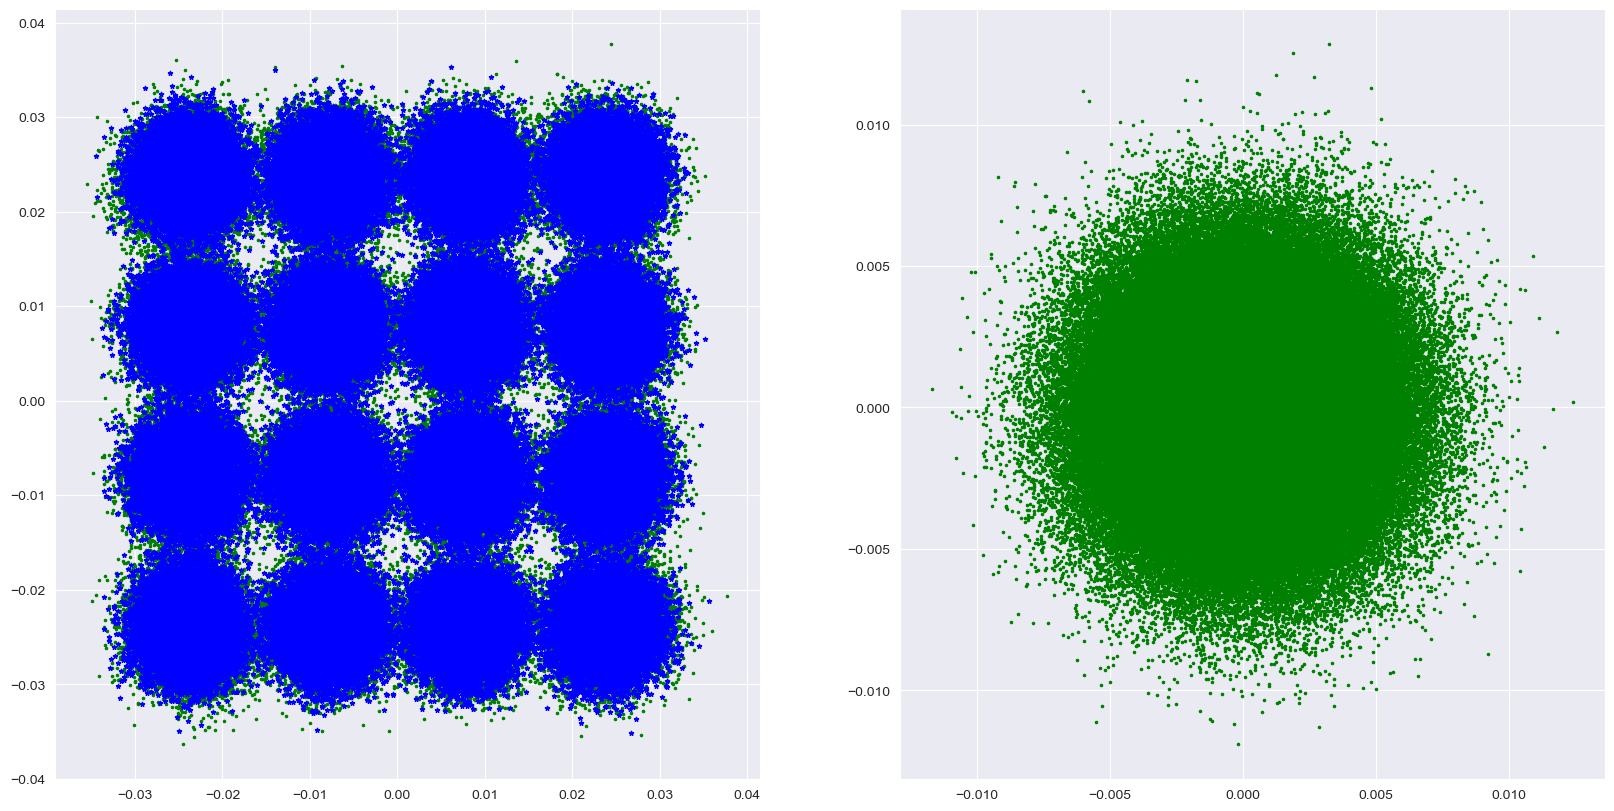

In [10]:
# plot the points
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].scatter(ps_test.real,
               ps_test.imag,
               s=10, c='green', marker='.')
axs[0].scatter(ps_final_test.real,
               ps_final_test.imag,
               s=10, c='blue', marker='*')
axs[0].grid(True)

axs[1].scatter((ps_test - ps_won_test).real,
               (ps_test - ps_won_test).imag,
               s=10, c='green', marker='.')

In [7]:
data_dir = 'C:/Users/190243539/PycharmProjects/nn_essential/benchmark/data/errorstat_channel_noise/'
filename_prefix = "data_collected_errorstat_onepol_pilot_channel_noise_1_nch_1_pavedbm_"

p_ave_dbm = 0
df_check = pd.read_pickle(data_dir + filename_prefix + str(p_ave_dbm) + "_fit.pkl")

# loglik_columns = df_check.filter(regex='(loglik$|prob)', axis=1)
loglik_columns = df_check.filter(regex='(loglik)', axis=1)
print(loglik_columns)


# filename = "data_collected_errorstat_onepol_wo_noise_1_nch_1_pavedbm_" + str(p_ave_dbm) + ".pkl"
# df = pd.read_pickle(data_dir + filename)

         h1_loglik    h2_loglik    h3_loglik
0    -76459.917523 -1790.939731 -1790.465418
1    -77353.110139 -1962.232147 -1963.077688
2    -76098.866644 -1939.810473 -1937.743800
3    -75090.771676 -1633.463312 -1630.948344
4    -76578.310998 -1909.015745 -1908.623009
...            ...          ...          ...
4091 -76132.994453 -1814.441306 -1813.150215
4092 -75680.862244 -1893.146954 -1885.704045
4093 -72964.361661 -1654.668799 -1654.533023
4094 -74741.137143 -1744.959474 -1741.850255
4095 -76880.204323 -1938.814230 -1937.281856

[4096 rows x 3 columns]


In [14]:
for col in df_check.columns:
    print(col)

left_point_real
left_point_imag
central_point_real
central_point_imag
right_point_real
right_point_imag
h1_loglik
h1_prob_1
h1_mean0_1
h1_mean1_1
h1_cov00_1
h1_cov01_1
h1_cov10_1
h1_cov11_1
h1_eig0_1
h1_eig1_1
h2_loglik
h2_prob_1
h2_mean0_1
h2_mean1_1
h2_cov00_1
h2_cov01_1
h2_cov10_1
h2_cov11_1
h2_eig0_1
h2_eig1_1
h2_prob_2
h2_mean0_2
h2_mean1_2
h2_cov00_2
h2_cov01_2
h2_cov10_2
h2_cov11_2
h2_eig0_2
h2_eig1_2
h3_loglik
h3_prob_1
h3_mean0_1
h3_mean1_1
h3_cov00_1
h3_cov01_1
h3_cov10_1
h3_cov11_1
h3_eig0_1
h3_eig1_1
h3_prob_2
h3_mean0_2
h3_mean1_2
h3_cov00_2
h3_cov01_2
h3_cov10_2
h3_cov11_2
h3_eig0_2
h3_eig1_2
h3_prob_3
h3_mean0_3
h3_mean1_3
h3_cov00_3
h3_cov01_3
h3_cov10_3
h3_cov11_3
h3_eig0_3
h3_eig1_3
h4_loglik
h4_prob_1
h4_mean0_1
h4_mean1_1
h4_cov00_1
h4_cov01_1
h4_cov10_1
h4_cov11_1
h4_eig0_1
h4_eig1_1
h4_prob_2
h4_mean0_2
h4_mean1_2
h4_cov00_2
h4_cov01_2
h4_cov10_2
h4_cov11_2
h4_eig0_2
h4_eig1_2
h4_prob_3
h4_mean0_3
h4_mean1_3
h4_cov00_3
h4_cov01_3
h4_cov10_3
h4_cov11_3
h4_eig0_3
h4

In [6]:
df_check

left_point_real  left_point_imag  central_point_real  \
0                -3.0              3.0                -3.0   
1                -3.0              3.0                -3.0   
2                -3.0              3.0                -3.0   
3                -3.0              3.0                -3.0   
4                -3.0              3.0                -3.0   
...               ...              ...                 ...   
4091              1.0             -1.0                 1.0   
4092              1.0             -1.0                 1.0   
4093              1.0             -1.0                 1.0   
4094              1.0             -1.0                 1.0   
4095              1.0             -1.0                 1.0   

      central_point_imag  right_point_real  right_point_imag     h1_loglik  \
0                    3.0              -3.0               3.0 -77487.899781   
1                    3.0              -1.0               3.0 -78637.884006   
2                    3.0               3.0               3.0 -79309.335351   
3                    3.0               1.0               3.0 -78528.757558   
4                    3.0              -3.0               1.0 -79823.120087   
...                  ...               ...               ...           ...   
4091                -1.0               1.0              -3.0 -79150.509772   
4092                -1.0              -3.0              -1.0 -80124.291700   
4093                -1.0              -1.0              -1.0 -79130.979125   
4094                -1.0               3.0              -1.0 -78644.714116   
4095                -1.0               1.0              -1.0 -77772.002170   

      h1_prob_1  h1_mean0_1  h1_mean1_1  h1_cov00_1  h1_cov01_1  h1_cov10_1  \
0      0.000125    0.003652    0.003253    0.114881    0.002311    0.002311   
1      0.000123   -0.002707   -0.003248    0.118431    0.001044    0.001044   
2      0.000122   -0.002128   -0.001677    0.118297   -0.000515   -0.000515   
3      0.000123    0.001537   -0.004836    0.113634   -0.000719   -0.000719   
4      0.000121    0.003081    0.005754    0.118996    0.000688    0.000688   
...         ...         ...         ...         ...         ...         ...   
4091   0.000122   -0.001269   -0.005166    0.113277   -0.001385   -0.001385   
4092   0.000121   -0.003076    0.004875    0.113462    0.000740    0.000740   
4093   0.000123    0.002483   -0.000064    0.115701    0.000197    0.000197   
4094   0.000123   -0.002550    0.003078    0.115764    0.000839    0.000839   
4095   0.000124   -0.002143    0.003774    0.116037   -0.002870   -0.002870   

      h1_cov11_1  h1_eig0_1  h1_eig1_1    h2_loglik  h2_prob_1  h2_mean0_1  \
0       0.112387   0.116260   0.111009 -5317.024137   0.485176   -0.077041   
1       0.117276   0.119047   0.116661 -5669.551003   0.456200    0.097937   
2       0.114287   0.118362   0.114222 -5611.638506   0.148950   -0.187026   
3       0.111994   0.113905   0.111724 -5330.848408   0.446019    0.061507   
4       0.110711   0.119053   0.110654 -5543.006500   0.532965   -0.045707   
...          ...        ...        ...          ...        ...         ...   
4091    0.113038   0.114548   0.111768 -5391.664575   0.306086   -0.101830   
4092    0.114967   0.113160   0.115269 -5522.437554   0.386592   -0.169459   
4093    0.116949   0.115671   0.116979 -5602.679067   0.338176   -0.193596   
4094    0.116130   0.115088   0.116805 -5547.317298   0.486419   -0.144839   
4095    0.116010   0.118894   0.113153 -5493.706552   0.435247   -0.020604   

      h2_mean1_1  h2_cov00_1  h2_cov01_1  h2_cov10_1  h2_cov11_1  h2_eig0_1  \
0      -0.124288    0.108487   -0.001627   -0.001627    0.093154   0.108658   
1      -0.134513    0.112245    0.012431    0.012431    0.097358   0.119291   
2       0.090334    0.111055    0.012977    0.012977    0.105485   0.121543   
3       0.112610    0.111485   -0.005165   -0.005165    0.101679   0.113704   
4       0.137006    0.114923    0.006283   

In [92]:
loglik_columns

h1_loglik  h1_prob_1    h2_loglik  h2_prob_1  h2_prob_2    h3_loglik  \
0    -33005.433723   0.000242  1409.089672   0.689810   0.310190  1419.019652   
1    -32738.708720   0.000242  1647.754108   0.515763   0.484237  1650.035771   
2    -34450.999859   0.000236  1045.126605   0.663771   0.336229  1059.707382   
3    -32034.481854   0.000248  1525.840543   0.644689   0.355311  1529.032320   
4    -31560.349757   0.000250  1595.245179   0.668148   0.331852  1600.530885   
...            ...        ...          ...        ...        ...          ...   
4091 -30810.559877   0.000241  3834.392204   0.367210   0.632790  3833.758847   
4092 -29729.666589   0.000246  4020.351024   0.809003   0.190997  4021.370770   
4093 -28395.730145   0.000250  4790.611126   0.674944   0.325056  4793.068950   
4094 -30133.677155   0.000245  3818.552731   0.803085   0.196915  3823.303022   
4095 -28324.860960   0.000253  4462.689759   0.588581   0.411419  4477.042137   

      h3_prob_1  h3_prob_2  h3_prob_3    h4_loglik  h4_prob_1  h4_prob_2  \
0      0.376705   0.462393   0.160901  1422.500458   0.345662   0.257882   
1      0.437634   0.223823   0.338543  1655.421341   0.185115   0.313772   
2      0.386333   0.240046   0.373621  1069.981616   0.237470   0.107104   
3      0.277585   0.191186   0.531229  1528.088012   0.184507   0.318167   
4      0.325182   0.360778   0.314040  1601.937069   0.127045   0.312765   
...         ...        ...        ...          ...        ...        ...   
4091   0.373253   0.383560   0.243187  3838.672229   0.206043   0.563262   
4092   0.365145   0.308863   0.325992  4023.414262   0.371916   0.144331   
4093   0.350891   0.240135   0.408974  4798.526646   0.229763   0.246598   
4094   0.236402   0.423166   0.340432  3822.392747   0.381696   0.340961   
4095   0.306252   0.406084   0.287664  4477.798466   0.277534   0.139171   

      h4_prob_3  h4_prob_4    h5_loglik  h5_prob_1  h5_prob_2  h5_prob_3  \
0      0.207618   0.188837  1426.222498   0.285971   0.181584   0.042738   
1      0.193251   0.307862  1652.718034   0.222293   0.174283   0.162690   
2      0.336446   0.318980  1070.424508   0.148409   0.164637   0.217828   
3      0.084343   0.412983  1531.772091   0.258458   0.245377   0.218812   
4      0.253388   0.306801  1599.556316   0.247347   0.174303   0.246610   
...         ...        ...          ...        ...        ...        ...   
4091   0.154513   0.076182  3837.366855   0.294720   0.319406   0.109835   
4092   0.359850   0.123904  4022.588034   0.250758   0.152022   0.168705   
4093   0.230944   0.292695  4799.650240   0.168063   0.141513   0.253930   
4094   0.087492   0.189850  3826.032285   0.353687   0.257150   0.072964   
4095   0.038955   0.544340  4481.176450   0.207209   0.135153   0.269324   

      h5_prob_4  h5_prob_5  
0      0.164890   0.324817  
1      0.272269   0.168465  
2      0.240594   0.228533  
3      0.091617   0.185736  
4      0.187569   0.144172  
...         ...        ...  
4091   0.108950   0.167089  
4092   0.172985   0.255529  
4093   0.184156   0.252339  
4094   0.148246   0.167954  
4095   0.242100   0.146214  

[4096 rows x 20 columns]

In [105]:
def make_distribution(df, triplet, x_min=-10, x_max=10, y_min=-10, y_max=10, n_bins=1000):
    
    epsilon = 1e-10
    condition = (
        np.isclose(df.left_point_real, np.real(triplet[0]), atol=epsilon) &
        np.isclose(df.left_point_imag, np.imag(triplet[0]), atol=epsilon) &
        np.isclose(df.central_point_real, np.real(triplet[1]), atol=epsilon) &
        np.isclose(df.central_point_imag, np.imag(triplet[1]), atol=epsilon) &
        np.isclose(df.right_point_real, np.real(triplet[2]), atol=epsilon) &
        np.isclose(df.right_point_imag, np.imag(triplet[2]), atol=epsilon)
    )
    
    df_one = df[condition]
    
    # Extracting parameters for the first Gaussian
    mean_1 = df_one[['h2_mean0_1', 'h2_mean1_1']].values[0]
    cov_1 = df_one[['h2_cov00_1', 'h2_cov01_1', 'h2_cov10_1', 'h2_cov11_1']].values.reshape(2, 2)
    weight_1 = df_one['h2_prob_1'].values[0]
    
    # Extracting parameters for the second Gaussian
    mean_2 = df_one[['h2_mean0_2', 'h2_mean1_2']].values[0]
    cov_2 = df_one[['h2_cov00_2', 'h2_cov01_2', 'h2_cov10_2', 'h2_cov11_2']].values.reshape(2, 2)
    weight_2 = df_one['h2_prob_2'].values[0]
    
    # Generate grid of points
    x, y = np.linspace(x_min, x_max, n_bins), np.linspace(y_min, y_max, n_bins)
    X, Y = np.meshgrid(x, y)
    pos = np.dstack((X, Y))
    
    # Evaluate the GMM probability density function at each grid point
    pdf = (weight_1 * multivariate_normal(mean_1, cov_1).pdf(pos) +
           weight_2 * multivariate_normal(mean_2, cov_2).pdf(pos))
    
    # Set up the GMM parameters from your data
    gmm = GaussianMixture(n_components=2)
    gmm.weights_ = df_one[['h2_prob_1', 'h2_prob_2']].values[0]
    gmm.means_ = df_one[['h2_mean0_1', 'h2_mean1_1', 'h2_mean0_2', 'h2_mean1_2']].values.reshape(2, 2)
    gmm.covariances_ = df_one[['h2_cov00_1', 'h2_cov01_1', 'h2_cov10_1', 'h2_cov11_1', 
                            'h2_cov00_2', 'h2_cov01_2', 'h2_cov10_2', 'h2_cov11_2']].values.reshape(2, 2, 2)
    gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(gmm.covariances_))

    
    # # Plotting
    # plt.contour(X, Y, pdf, cmap='viridis')
    # plt.scatter(mean_1[0], mean_1[1], color='red', label='Mean 1')
    # plt.scatter(mean_2[0], mean_2[1], color='blue', label='Mean 2')
    # plt.legend()
    # plt.xlabel('X-axis')
    # plt.ylabel('Y-axis')
    # plt.title('Gaussian Mixture Model')
    # plt.show()
    
    # # 3D Histogram Plotting
    # fig = plt.figure()
    # ax = fig.add_subplot(111, projection='3d')
    # hist, xedges, yedges = np.histogram2d(X.ravel(), Y.ravel(), bins=n_bins, weights=pdf.ravel())
    # xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
    # xpos = xpos.ravel()
    # ypos = ypos.ravel()
    # zpos = 0
    # dx = dy = 0.5 * np.ones_like(zpos)
    # dz = hist.ravel()
    # ax.bar3d(xpos, ypos, zpos, dx, dy, dz, shade=True)
    # ax.set_xlabel('X-axis')
    # ax.set_ylabel('Y-axis')
    # ax.set_zlabel('Frequency')
    # plt.show()
    
    return gmm

# # Acceptance-rejection sampling
# def generate_samples(pdf, n, M, min=-1, max=1):
#     samples = []
#     # M = 0.05  # Adjust M based on your PDF and domain
#     while len(samples) < n:
#         x, y = np.random.uniform(min, max, 2)  # Adjust bounds based on your domain
#         z = pdf([x, y])
#         if np.random.uniform(0, M) < z:
#             samples.append([x, y, z])
#     return np.array(samples)

def get_points_for_triplet(df, triplet, centered=True):
    epsilon = 1e-10
    condition = (
        np.isclose(df.orig_m1_real, np.real(triplet[0]), atol=epsilon) &
        np.isclose(df.orig_m1_imag, np.imag(triplet[0]), atol=epsilon) &
        np.isclose(df.orig_real, np.real(triplet[1]), atol=epsilon) &
        np.isclose(df.orig_imag, np.imag(triplet[1]), atol=epsilon) &
        np.isclose(df.orig_p1_real, np.real(triplet[2]), atol=epsilon) &
        np.isclose(df.orig_p1_imag, np.imag(triplet[2]), atol=epsilon)
    )
    
    df_one = df[condition]
    
    points_shifted_one = df_one.shifted_real.values + 1j * df_one.shifted_imag.values
    if centered:
        return points_shifted_one - triplet[1]
    else:
        return points_shifted_one

In [106]:
triplet = (1+1j, 1+1j, 1+1j)
gmm = make_distribution(df_check, triplet=triplet, 
                  x_min=-1,
                  x_max=1,
                  y_min=-1,
                  y_max=1,
                  n_bins=100)

points = get_points_for_triplet(df, triplet, centered=True)

AttributeError: 'DataFrame' object has no attribute 'orig_m1_real'

C:\Users\190243539\AppData\Local\Temp\ipykernel_23400\3103003853.py:29: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



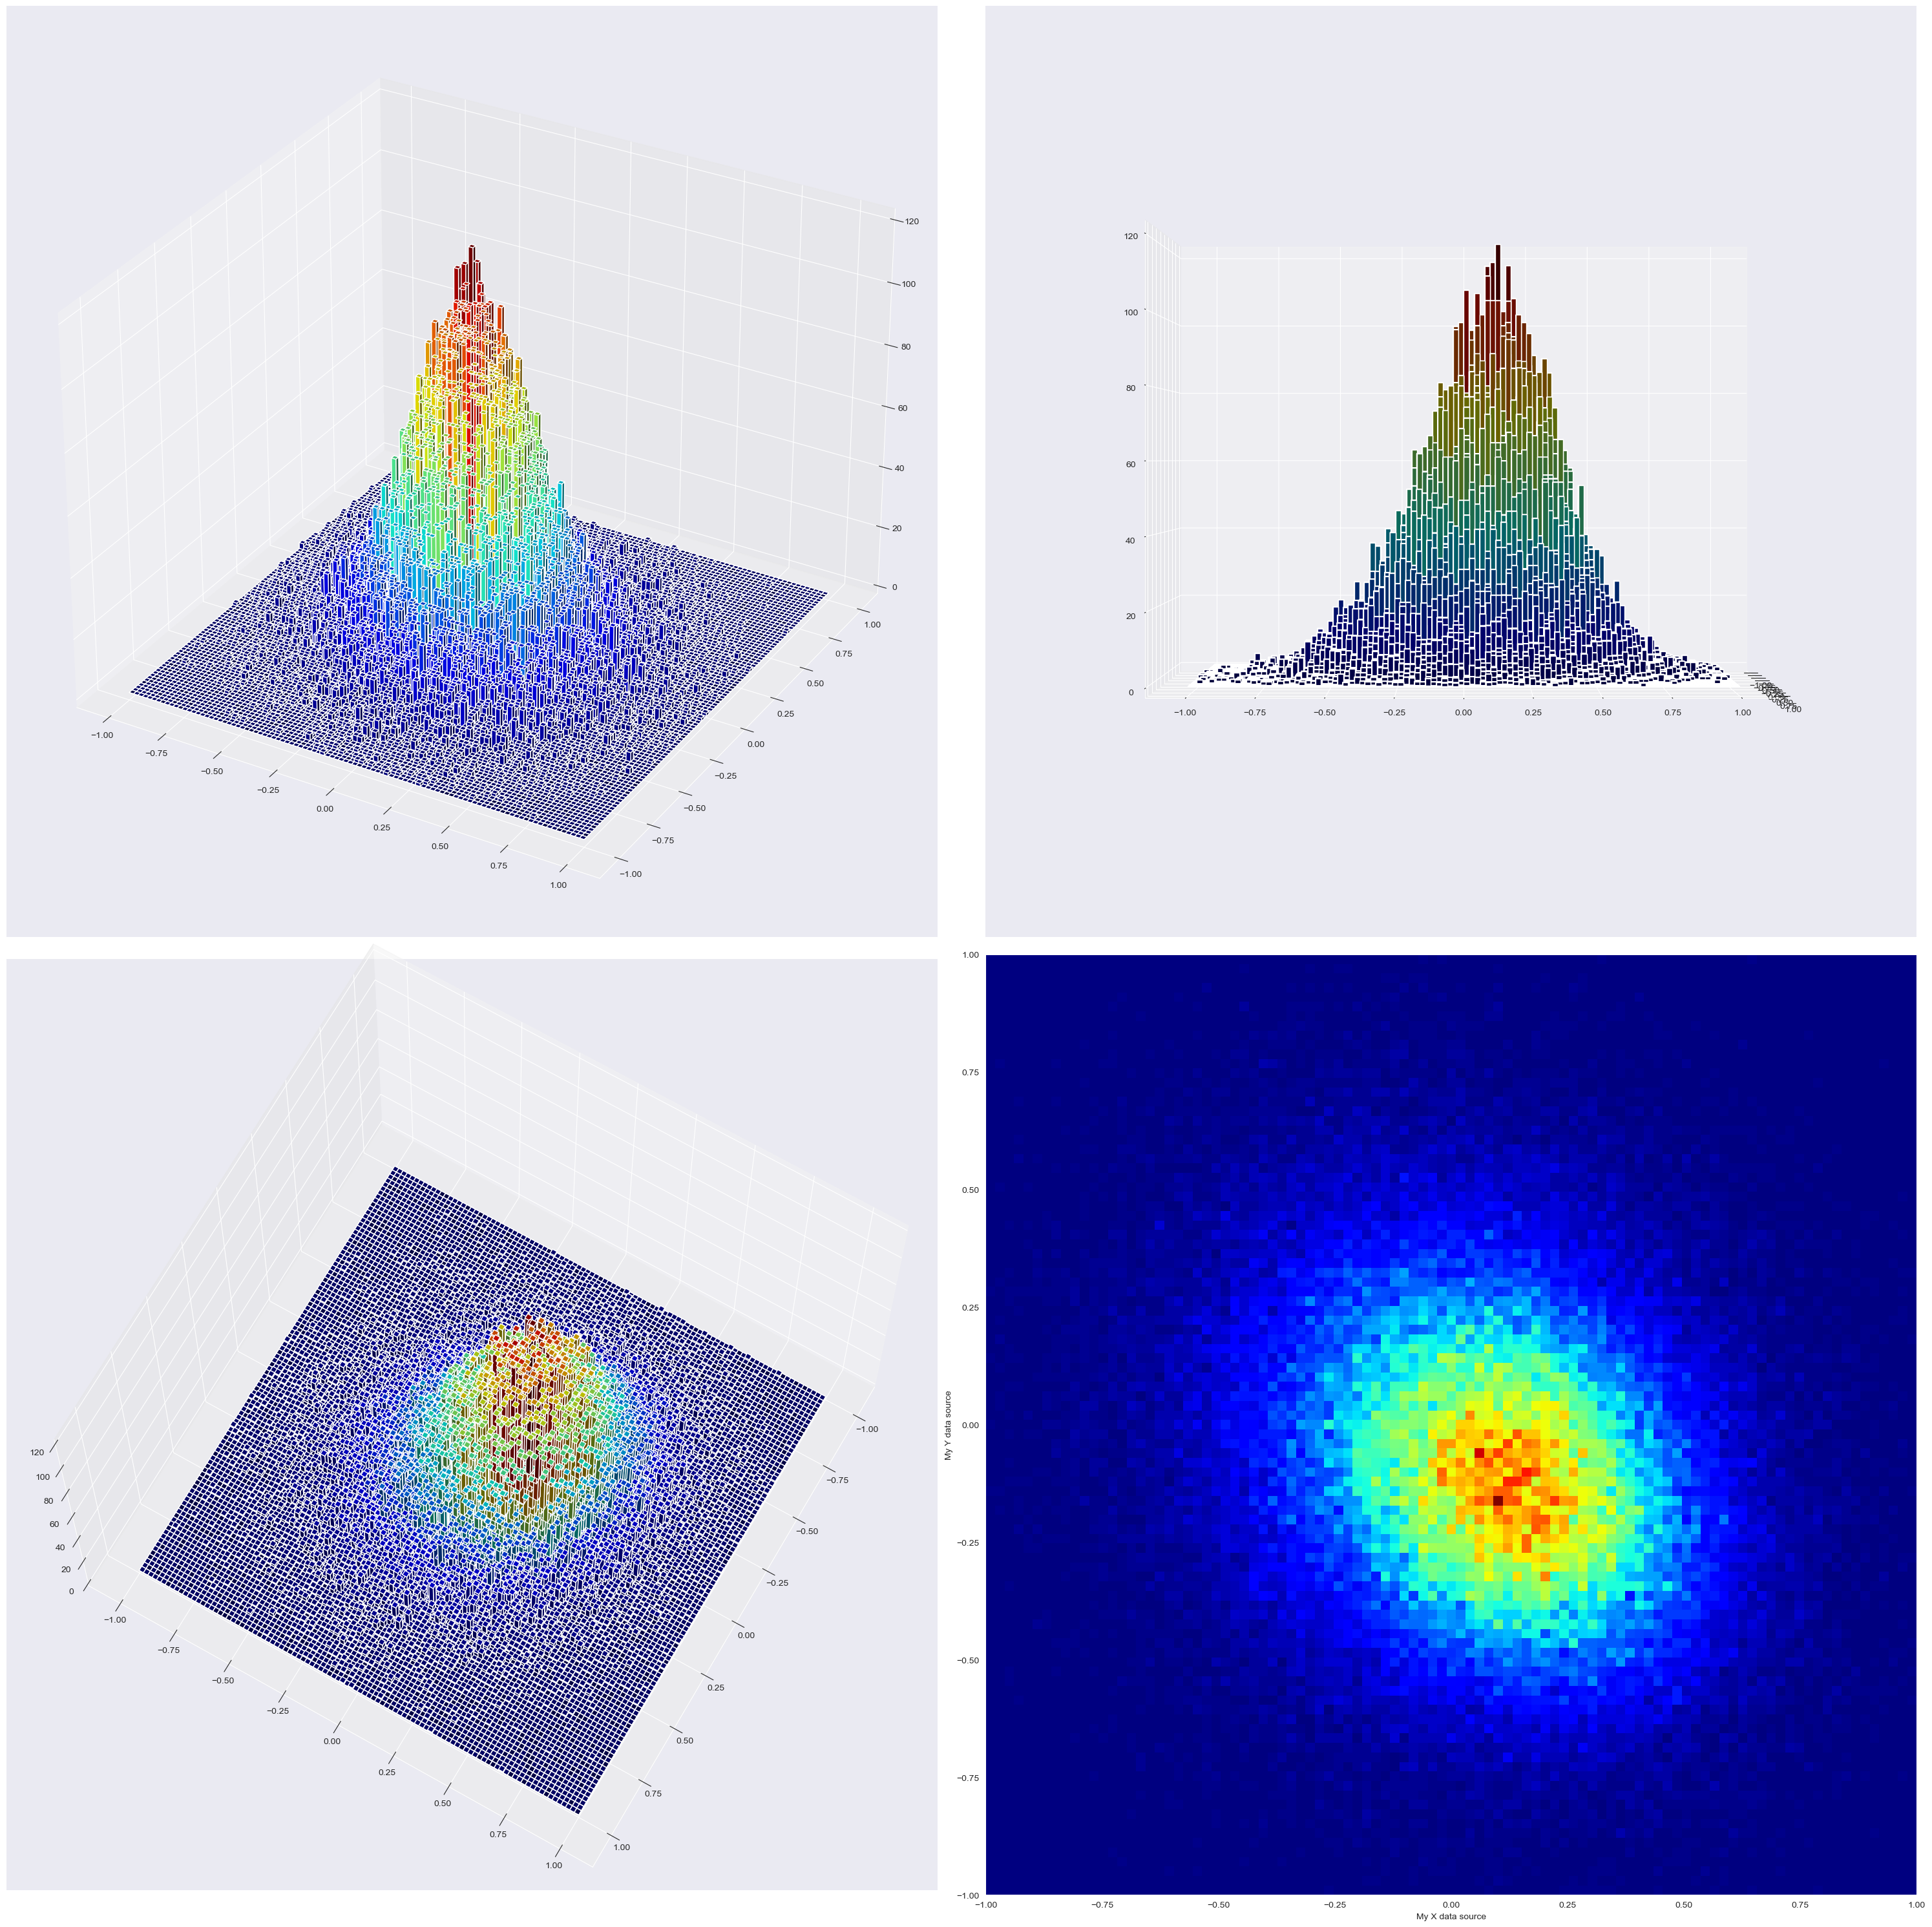

In [78]:
# Sample N data points
N = 10000
X, _ = gmm.sample(N)

# Set up the histogram bins and ranges
plot_max_value = 1
x_min, x_max = -plot_max_value, plot_max_value
y_min, y_max = x_min, x_max
n_bins = 100
x_bins = np.linspace(x_min, x_max, n_bins)
y_bins = np.linspace(y_min, y_max, n_bins)

# Get the x and y data from the generated samples
x = X[:, 0]
y = X[:, 1]

# Create the 2D histogram
hist, xedges, yedges = np.histogram2d(x, y, bins=(n_bins, n_bins), range=[[x_min, x_max], [y_min, y_max]])

# Set up the bar positions and dimensions
xpos, ypos = np.meshgrid(xedges[:-1]+xedges[1:], yedges[:-1]+yedges[1:]) -(xedges[1]-xedges[0])
xpos = xpos.flatten()*1./2
ypos = ypos.flatten()*1./2
zpos = np.zeros_like(xpos)
dx = dy = xedges[1] - xedges[0]
dz = hist.flatten()

# Set up the color map and normalize the bar heights
cmap = cm.get_cmap('jet')
max_height = np.max(dz)
min_height = np.min(dz)
rgba = [cmap((k-min_height)/max_height) for k in dz]

# Create the figure and subplots
fig = plt.figure(figsize=(30,30))
ax = fig.add_subplot(221, projection='3d')
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=rgba, zsort='average')

ax2 = fig.add_subplot(222, projection='3d')
ax2.bar3d(xpos, ypos, zpos, dx, dy, dz, color=rgba, zsort='average')
ax2.view_init(0, 0)

ax3 = fig.add_subplot(223, projection='3d')
ax3.bar3d(xpos, ypos, zpos, dx, dy, dz, color=rgba, zsort='average')
ax3.view_init(70, 30)

ax4 = fig.add_subplot(224)
ax4.hist2d(x, y, bins=[x_bins, y_bins], cmap=cmap)

# Label the axes
plt.xlabel("My X data source")
plt.ylabel("My Y data source")

# Set tight layout
plt.tight_layout()

# Display the plots
plt.show()

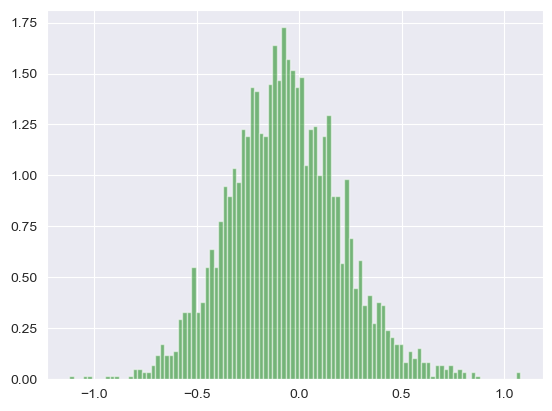

In [102]:
# Define the two points and the strip width
data = X
slice = [[0, 0], [1, 0]]
point1, point2 = np.array(slice[0]), np.array(slice[1])
strip_width = 0.02

# Compute the unit normal vector to the line
diff = point2 - point1
# normal = np.array([-diff[1], diff[0]])
normal = diff
unit_normal = normal / np.linalg.norm(normal)

# Define the strip boundaries
left_boundary = lambda p: np.dot(p - point1, unit_normal) >= -strip_width/2
right_boundary = lambda p: np.dot(p - point1, unit_normal) <= strip_width/2

# Filter the points within the strip
strip_points = data[left_boundary(data) & right_boundary(data)]
strip_points_complex = strip_points[:, 0] + 1j * strip_points[:, 1]
unit_normal_complex = unit_normal[0] + 1j * unit_normal[1]
strip_points_lined = np.abs(strip_points_complex) * np.exp(1j * (np.angle(strip_points_complex) - np.angle(unit_normal_complex)))


# Create a histogram
plt.hist(strip_points_lined.imag, bins=100, density=True, alpha=0.5, color='g')
plt.show()

In [27]:
p_ave_dbm_list = [0, -1, 1, -2, 2]
df_loglik = pd.DataFrame()
for p_ave_dbm in p_ave_dbm_list:
    df_check = pd.read_pickle(data_dir + filename_prefix + str(p_ave_dbm) + "_fit.pkl")

    # loglik_columns = df_check.filter(regex='(loglik$|prob)', axis=1)
    loglik_columns = df_check.filter(regex='(loglik)', axis=1).copy()
    loglik_columns['p_ave_dbm'] = p_ave_dbm
    df_loglik = pd.concat([df_loglik, loglik_columns], ignore_index=True)

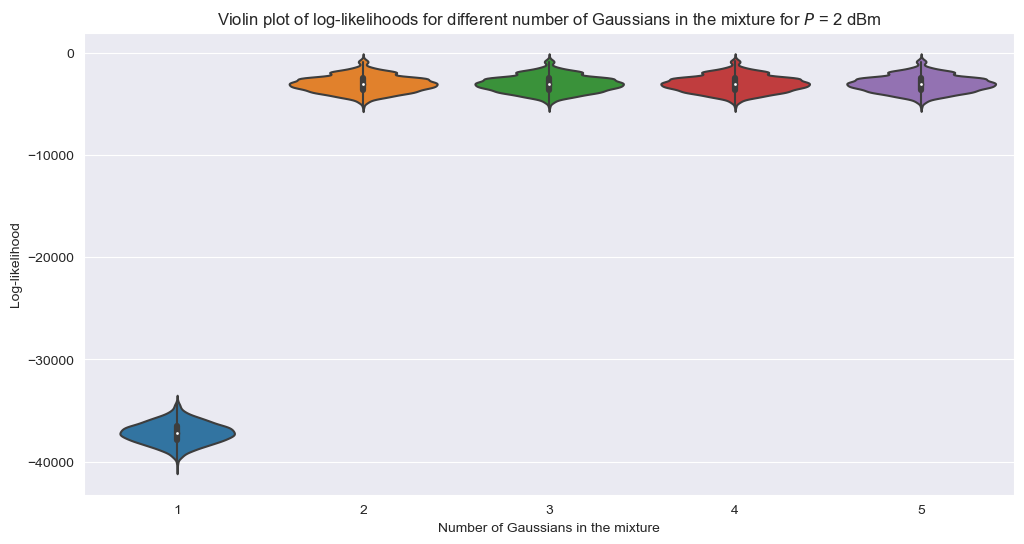

In [29]:
# cur_dir = os.getcwd()
cur_dir = 'C:/Users/190243539/PycharmProjects/nn_essential/error_statistics/'
p_ave_dbm = 2

plt.figure(figsize=(12, 6))
sns.violinplot(data=df_loglik[df_loglik['p_ave_dbm'] == p_ave_dbm].drop(columns=['p_ave_dbm']))
plt.title(f'Violin plot of log-likelihoods for different number of Gaussians in the mixture for $P$ = {p_ave_dbm} dBm')
plt.xlabel('Number of Gaussians in the mixture')
plt.ylabel('Log-likelihood')
plt.xticks(ticks=range(5), labels=[str(k) for k in range(1, 6)])
# plt.yscale('log')
plt.savefig(cur_dir + f'/img/loglik_pdbm_{p_ave_dbm}.png', dpi=300, format='png', bbox_inches='tight')
plt.savefig(cur_dir + f'/img/loglik_pdbm_{p_ave_dbm}.pdf', dpi=300, format='pdf', bbox_inches='tight')

plt.show()

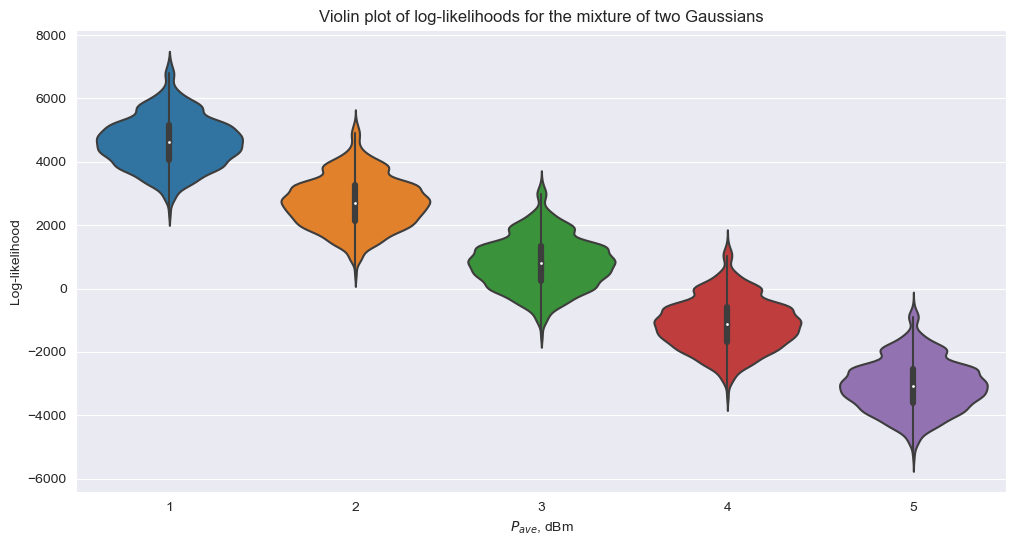

In [31]:
cur_dir = 'C:/Users/190243539/PycharmProjects/nn_essential/error_statistics/'
p_ave_dbm = 2

plt.figure(figsize=(12, 6))
sns.violinplot(x='p_ave_dbm', y='h2_loglik', data=df_loglik)
plt.title(f'Violin plot of log-likelihoods for the mixture of two Gaussians')
plt.xlabel(r'$P_{ave}$, dBm')
plt.ylabel('Log-likelihood')
plt.xticks(ticks=range(5), labels=[str(k) for k in range(1, 6)])
# plt.yscale('log')
plt.savefig(cur_dir + f'/img/loglik_2g.png', dpi=300, format='png', bbox_inches='tight')
plt.savefig(cur_dir + f'/img/loglik_2g.pdf', dpi=300, format='pdf', bbox_inches='tight')

plt.show()

In [ ]:
df_all_powers = form_dataframes(p_ave_dbm_list, data_dir, filename_prefix, m_shift=1, m_orig=1)

In [ ]:
df_all_powers

In [5]:
p_ave_dbm = -2
# filename = "data_collected_fornn_w_noise_1_nch_1_pavedbm_" + str(p_ave_dbm) + ".pkl"
filename = "data_collected_errorstat_onepol_wo_noise_1_nch_1_pavedbm_" + str(p_ave_dbm) + ".pkl"
df = pd.read_pickle(data_dir + filename)

In [96]:
df

run  n_channels  n_polarisations  n_symbols  p_ave_dbm  z_km  scale_coef  \
0     0           1                1     262144         -2  1200  125.892541   
1     1           1                1     262144         -2  1200  125.892541   
2     2           1                1     262144         -2  1200  125.892541   
3     3           1                1     262144         -2  1200  125.892541   
4     4           1                1     262144         -2  1200  125.892541   
..  ...         ...              ...        ...        ...   ...         ...   
59   59           1                1     262144         -2  1200  125.892541   
60   60           1                1     262144         -2  1200  125.892541   
61   61           1                1     262144         -2  1200  125.892541   
62   62           1                1     262144         -2  1200  125.892541   
63   63           1                1     262144         -2  1200  125.892541   

    noise_figure_db  gamma  z_span  dispersion_parameter  dz  \
0              -200    1.2      80                  16.8   1   
1              -200    1.2      80                  16.8   1   
2              -200    1.2      80                  16.8   1   
3              -200    1.2      80                  16.8   1   
4              -200    1.2      80                  16.8   1   
..              ...    ...     ...                   ...  ..   
59             -200    1.2      80                  16.8   1   
60             -200    1.2      80                  16.8   1   
61             -200    1.2      80                  16.8   1   
62             -200    1.2      80                  16.8   1   
63             -200    1.2      80                  16.8   1   

                                          points_orig  \
0   [[(-0.007943282347242814-0.007943282347242814j...   
1   [[(0.007943282347242814-0.007943282347242814j)...   
2   [[(0.007943282347242814-0.007943282347242814j)...   
3   [[(0.02382984704172844-0.007943282347242814j),...   
4   [[(0.007943282347242814-0.02382984704172844j),...   
..                                                ...   
59  [[(0.02382984704172844-0.02382984704172844j), ...   
60  [[(0.02382984704172844-0.02382984704172844j), ...   
61  [[(-0.007943282347242814+0.007943282347242814j...   
62  [[(-0.02382984704172844+0.007943282347242814j)...   
63  [[(0.02382984704172844+0.007943282347242814j),...   

                                               points  \
0   [[(-0.005733858546474419-0.011485822763175554j...   
1   [[(0.010483891877523497-0.0039679512865903755j...   
2   [[(0.010718044838525908-0.004041503131489028j)...   
3   [[(0.02514821893702988+0.004729565807900548j),...   
4   [[(0.01684332014663444-0.017610693316167027j),...   
..                                                ...   
59  [[(0.031021099467614395-0.011446286997019748j)...   
60  [[(0.0313601414359284-0.01066230893453591j), (...   
61  [[(-0.011144968616508006+0.005181512330511756j...   
62  [[(-0.0241866692796-0.005193277084417757j), (0...   
63  [[(0.016614192414844832+0.01740762877254661j),...   

                                       points_shifted  \
0   [[(-0.010373998237768836-0.007613078982964604j...   
1   [[(0.007533217044875788-0.008336640534740397j)...   
2   [[(0.007706969568031093-0.00851120441759683j),...   
3   [[(0.02459102211874496-0.007294041318698793j),...   
4   [[(0.006951151975986733-0.023416271297260333j)...   
..                                                ...   
59  [[(0.02240643199827702-0.02442303326773394j), ...   
60  [[(0.023069371134895964-0.023879734609870626j)...   
61  [[(-0.007556595382073407+0.009729593539458643j...   
62  [[(-0.023951159119801738+0.006417326839280026j...   
63  [[(0.022785208723255047+0.007913373572713166j)...   

                            ber                    q                    evm  \
0                    [(0.0, 0)]                [inf]  [0.21106544198952723]   
1   [(2.86102294921875e-06, 3)]  [4.536407905700565]  [0.2109

In [7]:
n_runs = 64
runs = [k for k in range(n_runs)]  # Replace with your list of runs
M = 1  # Number of neighbors on each side
dataset, target_dataset = form_datasets_triplets(df, runs, p_ave_dbm, M, M)
print(np.shape(dataset), np.shape(target_dataset))

64it [00:54,  1.18it/s]


(16777216, 6) (16777216, 6)


In [8]:
df_new = pd.concat([pd.DataFrame(dataset), pd.DataFrame(target_dataset)], axis=1).astype(float)
print(df_new.shape)

# df_new['point_orig_real'] = target_dataset[:, 0]
# df_new['point_orig_imag'] = target_dataset[:, 1]

C:\Users\190243539\anaconda3\envs\tfgpu_env\lib\site-packages\pandas\core\dtypes\cast.py:1181: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)


(16777216, 12)


In [9]:
# Rename columns for clarity
column_names = form_column_names(M, M)
print(column_names)
df_new.columns = column_names

['shifted_m1_real', 'shifted_m1_imag', 'shifted_real', 'shifted_imag', 'shifted_p1_real', 'shifted_p1_imag', 'orig_m1_real', 'orig_m1_imag', 'orig_real', 'orig_imag', 'orig_p1_real', 'orig_p1_imag']


In [10]:
df_new

shifted_m1_real  shifted_m1_imag  shifted_real  shifted_imag  \
0               -1.102710        -2.832565     -1.306009     -0.958430   
1               -1.306009        -0.958430      2.824582     -2.999973   
2                2.824582        -2.999973     -3.315361     -0.944752   
3               -3.315361        -0.944752      1.051571     -0.725264   
4                1.051571        -0.725264     -3.029603      3.295941   
...                   ...              ...           ...           ...   
16777211         3.168840        -2.763940     -2.832190     -3.564595   
16777212        -2.832190        -3.564595      2.630350      1.082321   
16777213         2.630350         1.082321     -3.022076      0.601964   
16777214        -3.022076         0.601964      2.659387      1.184227   
16777215         2.659387         1.184227      1.207678     -3.158621   

          shifted_p1_real  shifted_p1_imag  orig_m1_real  orig_m1_imag  \
0                2.824582        -2.999973          -1.0          -3.0   
1               -3.315361        -0.944752          -1.0          -1.0   
2                1.051571        -0.725264           3.0          -3.0   
3               -3.029603         3.295941          -3.0          -1.0   
4               -3.043500        -2.757817           1.0          -1.0   
...                   ...              ...           ...           ...   
16777211         2.630350         1.082321           3.0          -3.0   
16777212        -3.022076         0.601964          -3.0          -3.0   
16777213         2.659387         1.184227           3.0           1.0   
16777214         1.207678        -3.158621          -3.0           1.0   
16777215         2.868488         0.996235           3.0           1.0   

          orig_real  orig_imag  orig_p1_real  orig_p1_imag  
0              -1.0       -1.0           3.0          -3.0  
1               3.0       -3.0          -3.0          -1.0  
2              -3.0       -1.0           1.0          -1.0  
3               1.0       -1.0          -3.0           3.0  
4              -3.0        3.0          -3.0          -3.0  
...             ...        ...           ...           ...  
16777211       -3.0       -3.0           3.0           1.0  
16777212        3.0        1.0          -3.0           1.0  
16777213       -3.0        1.0           3.0           1.0  
16777214        3.0        1.0           1.0          -3.0  
16777215        1.0       -3.0           3.0           1.0  

[16777216 rows x 12 columns]

In [11]:
eng = matlab.engine.start_matlab()

In [56]:
path_to_save = data_dir + f'fitting_results_triplets_errorstat_onepol_wo_noise_1_nch_1_pavedbm_{p_ave_dbm}.pkl'
df_result = fit_triplets(df_new, path_to_save, eng, disp=False, H_max=3)

100%|██████████| 16/16 [00:36<00:00,  2.31s/it]


In [57]:
df_result

left_point_real  left_point_imag  central_point_real  central_point_imag  \
0              -3.0              3.0                -3.0                 3.0   
1              -1.0              3.0                -3.0                 3.0   
2               3.0              3.0                -3.0                 3.0   
3               1.0              3.0                -3.0                 3.0   
4              -3.0              1.0                -3.0                 3.0   
5              -1.0              1.0                -3.0                 3.0   
6               3.0              1.0                -3.0                 3.0   
7               1.0              1.0                -3.0                 3.0   
8              -3.0             -3.0                -3.0                 3.0   
9              -1.0             -3.0                -3.0                 3.0   
10              3.0             -3.0                -3.0                 3.0   
11              1.0             -3.0                -3.0                 3.0   
12             -3.0             -1.0                -3.0                 3.0   
13             -1.0             -1.0                -3.0                 3.0   
14              3.0             -1.0                -3.0                 3.0   
15              1.0             -1.0                -3.0                 3.0   

    right_point_real  right_point_imag     h1_loglik  h1_prob_1  h1_mean0_1  \
0               -3.0               3.0 -30293.318637   0.000248   -0.080159   
1               -3.0               3.0 -29358.481591   0.000252   -0.075950   
2               -3.0               3.0 -30842.015638   0.000247   -0.145604   
3               -3.0               3.0 -28838.772381   0.000257   -0.096839   
4               -3.0               3.0 -31105.270132   0.000242   -0.029852   
5               -3.0               3.0 -29622.762825   0.000251   -0.025654   
6               -3.0               3.0 -30979.361895   0.000245   -0.091022   
7               -3.0               3.0 -30101.420560   0.000248   -0.046130   
8               -3.0               3.0 -31769.624503   0.000241   -0.007803   
9               -3.0               3.0 -31486.429718   0.000242    0.000664   
10              -3.0               3.0 -32390.978475   0.000240   -0.070197   
11              -3.0               3.0 -31208.154083   0.000244   -0.019739   
12              -3.0               3.0 -31971.807497   0.000236   -0.006814   
13              -3.0               3.0 -31065.245753   0.000241    0.006723   
14              -3.0               3.0 -30806.701094   0.000247   -0.065416   
15              -3.0               3.0 -31412.671260   0.000241   -0.021433   

    h1_mean1_1  ...  h3_eig1_2  h3_prob_3  h3_mean0_3  h3_mean1_3  h3_cov00_3  \
0    -0.132850  ...   0.008527   0.359102   -0.189711   -0.251254    0.031579   
1    -0.092591  ...   0.008102   0.249784    0.047694    0.018134    0.021823   
2    -0.088686  ...   0.017219   0.076691    0.026776   -0.015590    0.041960   
3    -0.073513  ...   0.008325   0.373823   -0.035054   -0.061954    0.035027   
4    -0.079268  ...   0.062162   0.507067    0.019132   -0.011914    0.021687   
5    -0.039611  ...   0.033544   0.102083    0.095196    0.080673    0.020537   
6    -0.041433  ...   0.015331   0.175880   -0.216276   -0.133590    0.045837   
7    -0.024954  ...   0.024683   0.309490   -0.007893   -0.056182    0.028589   
8    -0.081738  ...   0.059914   0.336348    0.026101   -0.010702    0.013224   
9    -0.025427  ...   0.050620   0.362522    0.018307   -0.077716    0.016503   
10   -0.028077  ...   0.036613   0.402345   -0.025391    0.027179    0.022534   
11   -0.019026  ...   0.024418   0.365755    0.039113    0.012215    0.014280   
12   -0.062586  ...   0.040874   0.394749   -0.009619   -0.021489    0.017696   
13   -0.016709  ...   0.038382   0.327315   -0.045591    0.005538    0.024980   
14   -0.016485  ...   0.025273   0.501802   -0.032020    0.030892    0.025224   
15 

In [ ]:
# Terminate MATLAB engine
eng.quit()

## Example of distribution

In [31]:
triplet_left_point = -1.0 + -1.0j
triplet_central_point = -3.0 + -1.0j
triplet_right_point = -1.0 + -1.0j

epsilon = 1e-10
condition = (
    np.isclose(df_new.orig_m1_real, np.real(triplet_left_point), atol=epsilon) &
    np.isclose(df_new.orig_m1_imag, np.imag(triplet_left_point), atol=epsilon) &
    np.isclose(df_new.orig_real, np.real(triplet_central_point), atol=epsilon) &
    np.isclose(df_new.orig_imag, np.imag(triplet_central_point), atol=epsilon) &
    np.isclose(df_new.orig_p1_real, np.real(triplet_right_point), atol=epsilon) &
    np.isclose(df_new.orig_p1_imag, np.imag(triplet_right_point), atol=epsilon)
)

df_one = df_new[condition]

points_shifted_one = df_one.shifted_real.values + 1j * df_one.shifted_imag.values
points_shifted_one_centered = points_shifted_one - triplet_central_point
np.shape(points_shifted_one)

(3908,)

C:\Users\190243539\AppData\Local\Temp\ipykernel_179328\824325236.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet') # Get desired colormap - you can change this!


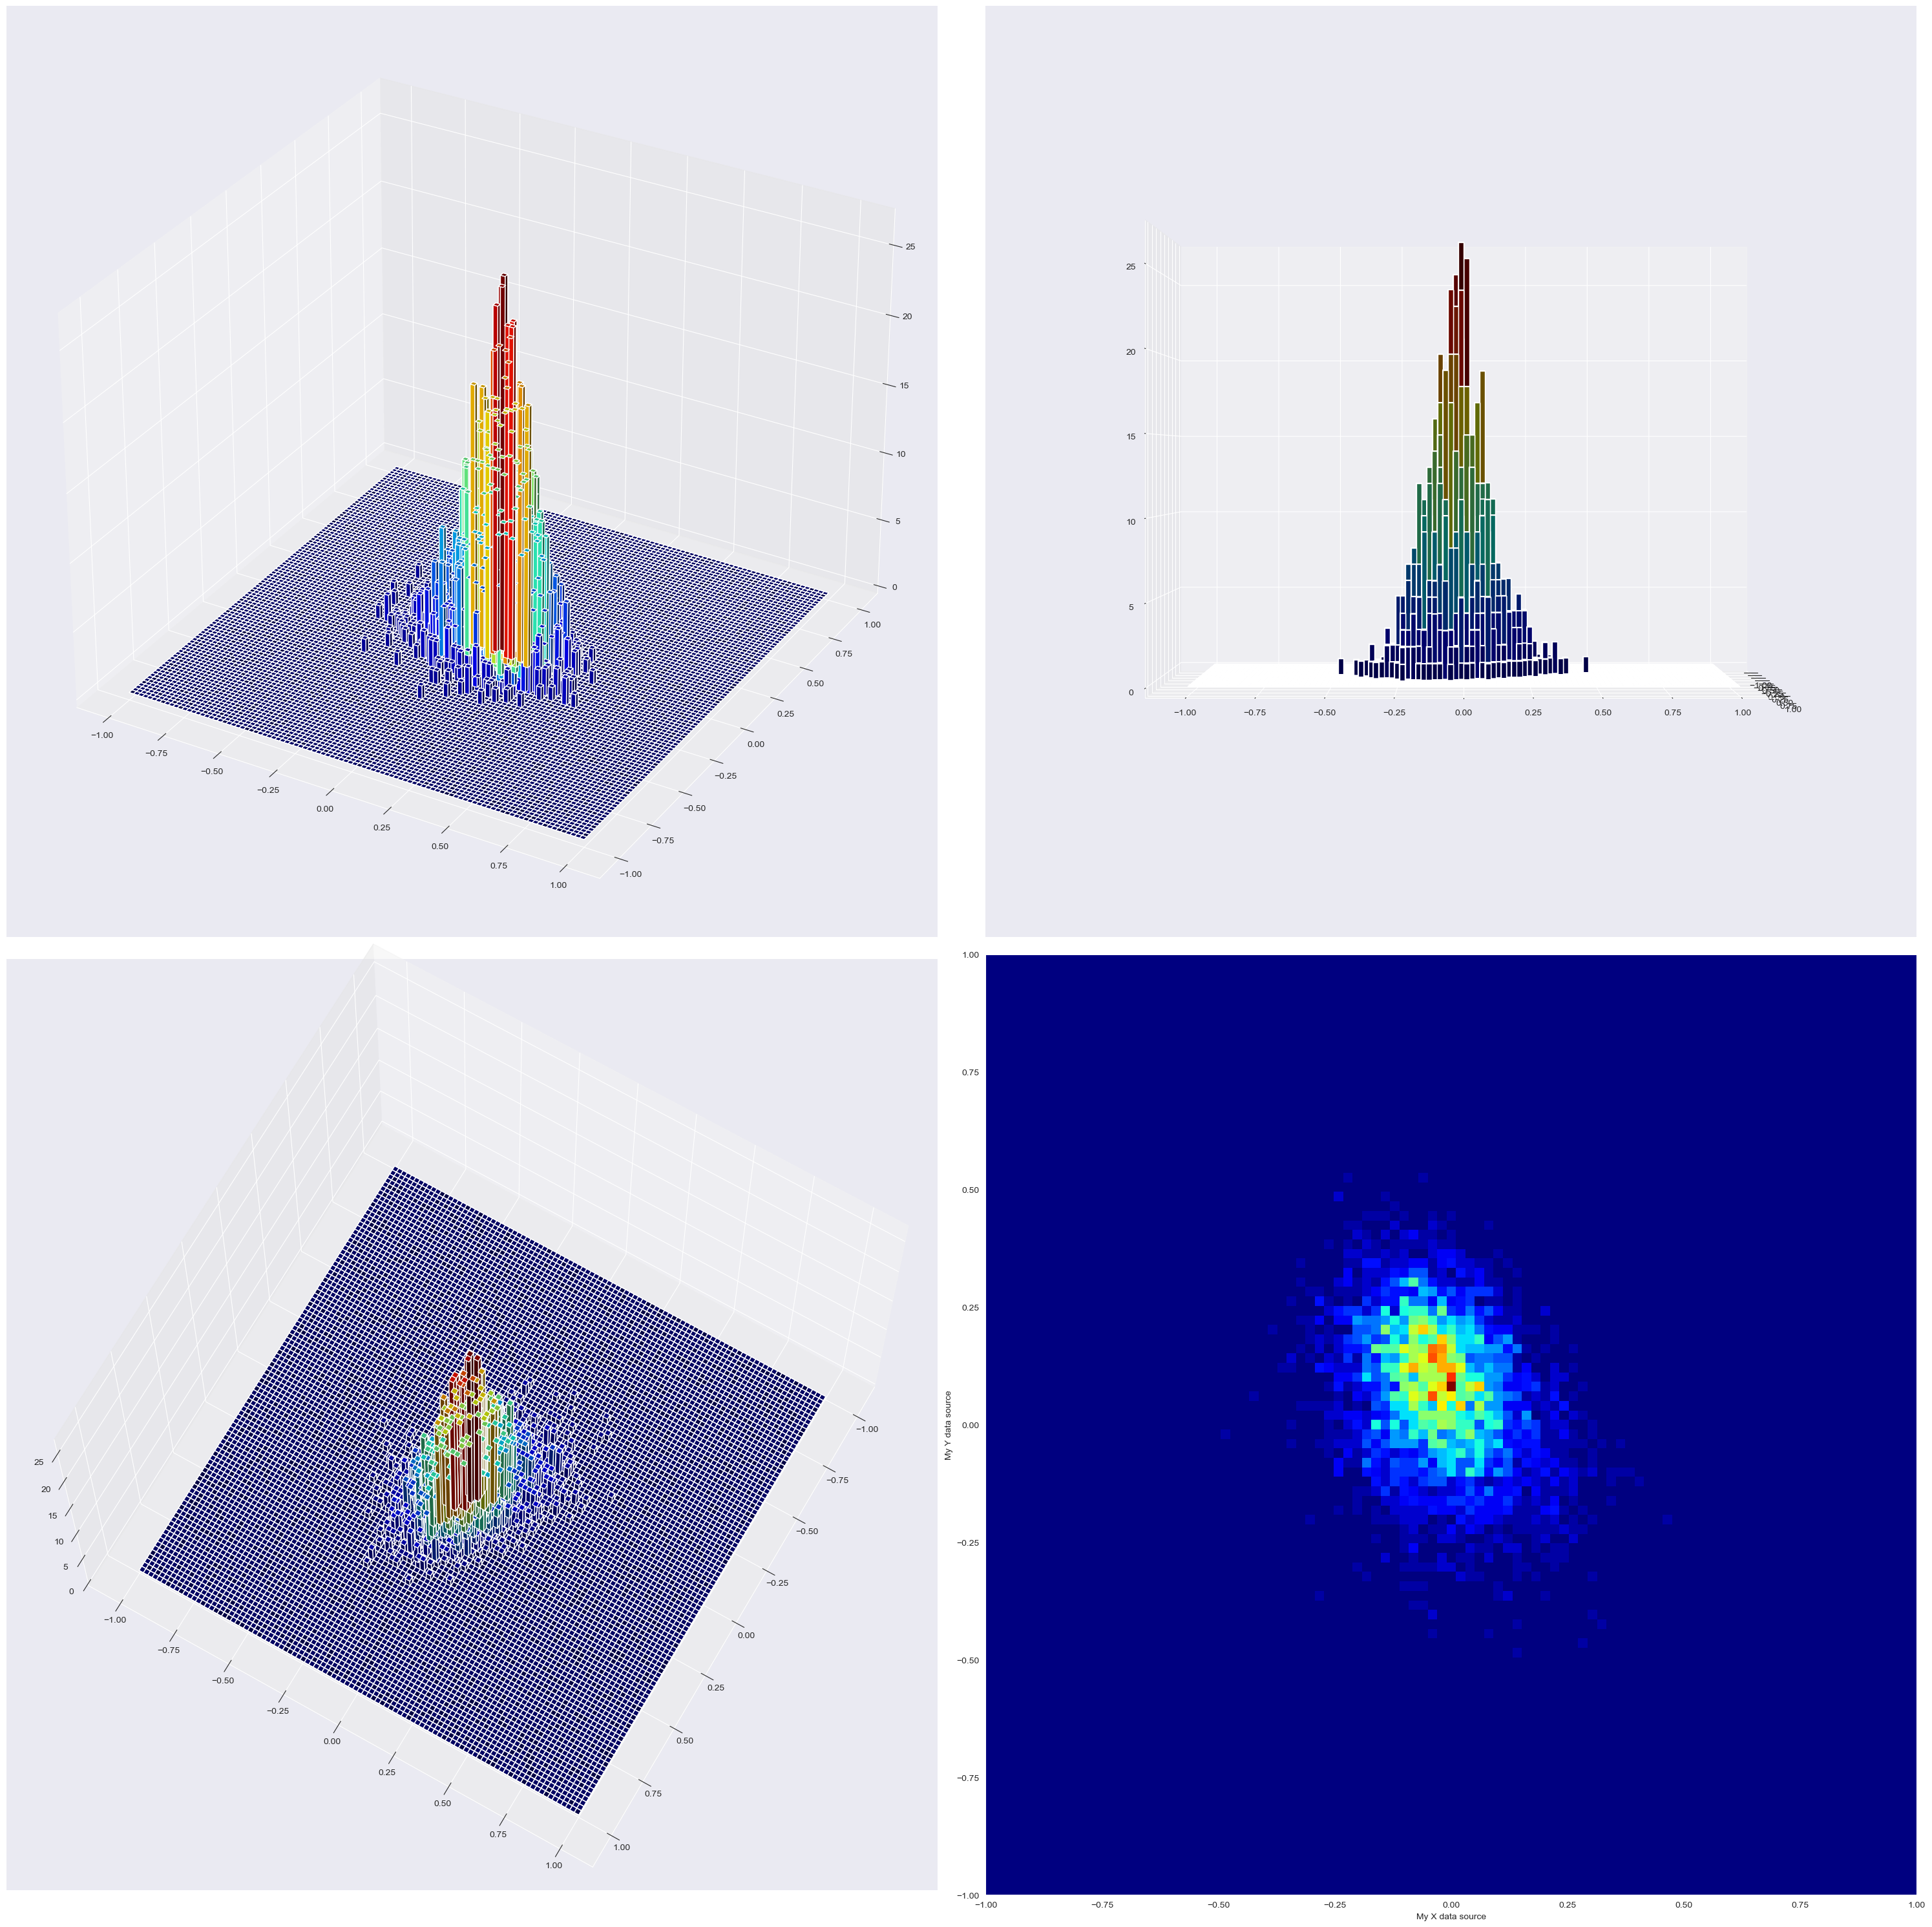

In [32]:
plot_max_value = 1
x_min, x_max = -plot_max_value, plot_max_value
y_min, y_max = x_min, x_max
n_bins = 100
x_bins = np.linspace(x_min, x_max, n_bins)
y_bins = np.linspace(y_min, y_max, n_bins)

x = points_shifted_one.real - triplet_central_point.real
# x = points_shifted_one.real
y = points_shifted_one.imag - triplet_central_point.imag
# y = points_shifted_one.imag
hist, xedges, yedges = np.histogram2d(x, y, bins=(n_bins,n_bins), range=[[x_min, x_max], [y_min, y_max]])

# Construct arrays for the anchor positions of the 16 bars.
xpos, ypos = np.meshgrid(xedges[:-1]+xedges[1:], yedges[:-1]+yedges[1:]) -(xedges[1]-xedges[0])

xpos = xpos.flatten()*1./2
ypos = ypos.flatten()*1./2
zpos = np.zeros_like (xpos)

dx = xedges[1] - xedges[0]
dy = yedges[1] - yedges[0]
dz = hist.flatten()

cmap = cm.get_cmap('jet') # Get desired colormap - you can change this!
max_height = np.max(dz)   # get range of colorbars so we can normalize
min_height = np.min(dz)
# scale each z to [0,1], and get their rgb values
rgba = [cmap((k-min_height)/max_height) for k in dz]

color_map = plt.cm.jet

fig = plt.figure(figsize=(30,30))
ax = fig.add_subplot(221, projection='3d')
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=rgba, zsort='average')

ax2 = fig.add_subplot(222, projection='3d')
ax2.bar3d(xpos, ypos, zpos, dx, dy, dz, color=rgba, zsort='average')
ax2.view_init(0, 0)

ax3 = fig.add_subplot(223, projection='3d')
ax3.bar3d(xpos, ypos, zpos, dx, dy, dz, color=rgba, zsort='average')
ax3.view_init(70, 30)

ax4 = fig.add_subplot(224)
# ax4.hexbin(xedges, yedges, hist, color=rgba)

ax4.hist2d(x, y, bins=[x_bins, y_bins], cmap=color_map)

# ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')
# plt.title("X vs. Y Amplitudes for ____ Data")
plt.xlabel("My X data source")
plt.ylabel("My Y data source")

# Set tight layout
plt.tight_layout()

# plt.savefig(data_dir + job_name + '.pdf', format="pdf")
plt.show()

(2, 3908)


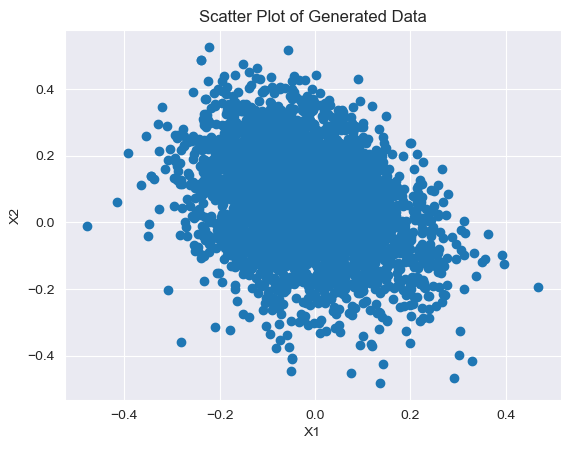

In [33]:
x = points_shifted_one.real - triplet_central_point.real
y = points_shifted_one.imag - triplet_central_point.imag
data_to_fit = np.stack((x, y), axis=0)
print(np.shape(data_to_fit))

# Create a scatter plot
plt.scatter(data_to_fit[0, :], data_to_fit[1, :])
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Scatter Plot of Generated Data')
# plt.colorbar(label='Component')
plt.grid(True)
plt.show()

In [51]:
eng = matlab.engine.start_matlab()

In [36]:
result = fit_gauss_matlab(data_to_fit, H=1, plotlik=1, plotsolution=1, maxit=50, minDeterminant=0.0001, eng=eng)
print(result)

-27043.691210043027 <class 'numpy.ndarray'>
{'P': array([0.00025589]), 'm': array([[-0.02339909,  0.07313028]]), 'S': array([[ 0.01235088, -0.00497591, -0.00497591,  0.02063213]]), 'eig': array([[0.01001815, 0.02296487]]), 'loglik': array(-27043.69121004), 'phgn': array([[0.00025589, 0.00025589, 0.00025589, ..., 0.00025589, 0.00025589,
        0.00025589]])}


In [66]:
for h_cur in [k for k in range(1, 6)]:
    result2 = fit_gauss_matlab(data_to_fit, H=h_cur, plotlik=1, plotsolution=1, maxit=50, minDeterminant=0.0001, eng=eng)
    print(result2['loglik'])

-27043.691210043027
5349.118725670191
5349.276828979898
5352.391353034384
5354.337989175955


In [ ]:
# Terminate MATLAB engine
eng.quit()